# Coastal Endurance Washington-Oregon Shelf Surface Mooring Data Comparison Report

** Evaluation Date**: 7/20/2018

** Evaluator**: Pichawut Manopkawee

## Review Summary
This report summarized a data comparison report of the Coastal Endurance between Washington and Oregon Shelf Surface Mooring Data (CE07SHSM,CE02SHSM). I focus on data from the full available dataset and narrow down to one year data  between 2015/12/1 and 2016/12/1. This report is not necessarily a comprehensive review of the instruments and quality of the data available. Instead, it explains the key comparison of dataset from two different sites within the same timestamps.

## 1. Coastal Endurance Array

![Coastal Endurance Array](http://oceanobservatories.org/wp-content/uploads/2018/03/CEV-OOI-Endurance-Array.jpg)

In this project, I focus on Washington and Oregon shelf surface mooring data which are derived by site 2 and 5, respectively.

## 2. Selected Instruments 

In this report, I will evaluate the CTD (particuarly temperature and seawater pressure), dissolved oxygen, nitrate, and 3-wavelength fluorometer (particularly chlorophyll concentration) from the Coastal Endurance on Washington and Oregon shelf. Additional instruments on the profiler are listed for reference and could be used for further evaluation.


Instrument | Reference Designator | Method | Stream 
 -- | -- | -- | --
CTD | CE02SHSM-RID27-03-CTDBPC000 | telemetered | ctdbp_cdef_dcl_instrument
CTD | CE07SHSM-RID27-03-CTDBPC000 | telemetered | ctdbp_cdef_dcl_instrument
Dissolved Oxygen | CE02SHSM-RID27-04-DOSTAD000 | telemetered | dosta_abcdjm_dcl_instrument
Dissolved Oxygen | CE07SHSM-RID27-04-DOSTAD000 | telemetered | dosta_abcdjm_dcl_instrument
Nitrate| CE02SHSM-RID26-07-NUTNRB000 | telemetered | nutnr_b_dcl_conc_instrument
Nitrate| CE07SHSM-RID26-07-NUTNRB000 | telemetered | nutnr_b_dcl_conc_instrument
Fluorometer | CE02SHSM-RID27-02-FLORTD000  | telemetered | flort_sample
Fluorometer | CE07SHSM-RID27-02-FLORTD000  | telemetered | flort_sample


In [0]:
# Instrument Information
site = 'CE02SHSM','CE07SHSM'
node = 'RID27','RID26'
instrument = ['03-CTDBPC000','04-DOSTAD000','07-NUTNRB000','02-FLORTD000']
method = 'telemetered'
stream = ['ctdbp_cdef_dcl_instrument','dosta_abcdjm_dcl_instrument','nutnr_b_dcl_conc_instrument','flort_sample']
VOCAB_BASE_URL = 'https://ooinet.oceanobservatories.org/api/m2m/12586/vocab/inv'

## 3. Time Periods of Interest

In this report, we will focusng on the following time periods for evaluation:
- April 2, 2015 to July 18, 2018 - All of Deployment 1-5 (see step 4)
- December 1, 2015 to December 1, 2016- Deployment 2-4 (sea step 5)

## 4. Related Metadata

In this section, I will review some of metadata available in the system to make sure it is present and correct.

Before I get started, I need to set up our Python environment with some libraries, variables and functions I will need later in this report.

In [0]:
USERNAME = ''
TOKEN =  ''

DATA_API = 'https://ooinet.oceanobservatories.org/api/m2m/12576/sensor/inv/'
VOCAB_API = 'https://ooinet.oceanobservatories.org/api/m2m/12586/vocab/inv'
ASSET_API = 'https://ooinet.oceanobservatories.org/api/m2m/12587'


In [0]:
# First, we need to add some more Python libraries
import requests
import datetime
import time
import pandas as pd

In [0]:
range(len(instrument))

range(0, 4)

In [0]:
# convert timestamps
  
def convert_time(ms):
  if ms != None:
    return datetime.datetime.utcfromtimestamp(ms/1000)
  else:
    return None


## 4a. Vocabulary Metadata

This is a review of basic vocabulary information (metadata) from the system to make sure that I work on the right instrument.

In [0]:
# Create the request URL (3 different ways)
# request_url = VOCAB_BASE_URL + '/'+site+'/'+ node+'/'+instrument # Good
# request_url = "%s/%s/%s/%s" % (VOCAB_BASE_URL,site,node,instrument) # Better
for i in range(len(instrument)):
    request_url ='/'.join((VOCAB_BASE_URL,site,node,instrument[i])) # Python wizard best
    
# Retrieve vocabulary information for a given instrument
    r = requests.get(request_url, auth=(USERNAME, TOKEN))
    data = r.json()
    print(i,data)

0 [{'@class': '.VocabRecord', 'model': 'SBE 16plusV2', 'manufacturer': 'Sea-Bird', 'vocabId': 75, 'refdes': 'CE02SHSM-RID27-03-CTDBPC000', 'instrument': 'CTD', 'tocL1': 'Coastal Endurance', 'tocL2': 'Oregon Shelf Surface Mooring', 'tocL3': 'Near Surface Instrument Frame', 'mindepth': 7.0, 'maxdepth': 7.0}]
1 [{'@class': '.VocabRecord', 'model': 'Optode 4831', 'manufacturer': 'Aanderaa', 'vocabId': 76, 'refdes': 'CE02SHSM-RID27-04-DOSTAD000', 'instrument': 'Dissolved Oxygen', 'tocL1': 'Coastal Endurance', 'tocL2': 'Oregon Shelf Surface Mooring', 'tocL3': 'Near Surface Instrument Frame', 'mindepth': 7.0, 'maxdepth': 7.0}]
2 []
3 [{'@class': '.VocabRecord', 'model': 'ECO Triplet-w', 'manufacturer': 'WET Labs', 'vocabId': 74, 'refdes': 'CE02SHSM-RID27-02-FLORTD000', 'instrument': '3-Wavelength Fluorometer', 'tocL1': 'Coastal Endurance', 'tocL2': 'Oregon Shelf Surface Mooring', 'tocL3': 'Near Surface Instrument Frame', 'mindepth': 7.0, 'maxdepth': 7.0}]


These look good, except the nitrate concentration. No basic vocabulary information is provided in from this instrument even if the instrument was deployed.

## 4b. Deployment Information
This is some information about the deployments for this instrument. I will grab all of the deployments available in the system and then output the date ranges, latitude/longitude, asset ID, and sensor ID for each.  

In [0]:
# Setup the API request url
df = pd.DataFrame() # Setup empty array
for i in range(len(instrument)): 
    data_request_url = ASSET_API + '/events/deployment/query'
    params = {
      'beginDT':'2015-04-02T00:00:00.000Z',
      'endDT':'2018-07-18T00:00:00.000Z',
      'refdes':site+'-'+node+'-'+instrument[i]}

    # Grab the information from the server
    r = requests.get(data_request_url, params=params, auth=(USERNAME, TOKEN))
    data = r.json()

    for d in data:
      df = df.append({
          'deployment': d['deploymentNumber'],
          'start': convert_time(d['eventStartTime']),
          'stop': convert_time(d['eventStopTime']),
          'latitude': d['location']['latitude'],
          'longitude': d['location']['longitude'],
          'sensor': d['sensor']['uid'],
          'asset_id': d['sensor']['assetId'],
        }, ignore_index=True)
df

,asset_id,deployment,latitude,longitude,sensor,start,stop
0,1676.0,1.0,44.63833,-124.30388,CGINS-CTDBPC-50012,2015-04-02 20:15:00,2015-09-22 07:48:00
1,791.0,2.0,44.63538,-124.30252,CGINS-CTDBPC-07243,2015-10-07 21:10:00,2016-05-16 21:09:00
2,1586.0,3.0,44.63565,-124.30427,CGINS-CTDBPC-50057,2016-05-17 21:23:00,2016-09-28 15:52:00
3,1678.0,4.0,44.63929,-124.30404,CGINS-CTDBPC-50011,2016-09-26 21:25:00,2017-04-22 13:24:00
4,1683.0,5.0,44.63580,-124.30388,CGINS-CTDBPC-50014,2017-04-20 17:23:00,2017-10-15 19:06:32
5,946.0,6.0,44.63925,-124.30407,CGINS-CTDBPC-50188,2017-10-10 02:21:08,2018-04-04 13:57:00
6,1662.0,7.0,44.63567,-124.30418,CGINS-CTDBPC-50007,2018-04-03 01:17:00,None
7,972.0,1.0,44.63833,-124.30388,CGINS-DOSTAD-00223,2015-04-02 20:15:00,2015-09-22 07:48:00
8,2858.0,2.0,44.63538,-124.30252,CGINS-DOSTAD-00482,2015-10-07 21:10:00,2016-05-16 21:09:00
9,192.0,3.0,44.63565,-124.30427,CGINS-DOSTAD-00313,2016-05-17 21:23:00,2016-09-28 15:52:00


## 4c. Annotations

Finally, let's pull any relevant annotations for the CTD, dissolved oxygen, nitrogen, and 3-wavelength fluorometer instruments.

In [0]:
df = pd.DataFrame() # Setup empty array

nodes = dict(RID27=['03-CTDBPC000','04-DOSTAD000','02-FLORTD000'],RID26=['07-NUTNRB000'])
sites = ['CE07SHSM','CE02SHSM']

for node, instrument in nodes.items():
    for site in sites:
        substr='{}-{}'.format(site, node)
        for ins in instrument:
            refdes ='{}-{}'.format(substr, ins)

            params = {
                'beginDT':int(datetime.date(2015,4,2).strftime('%s'))*1000,
                'endDT':int(datetime.date(2018,7,18).strftime('%s'))*1000,
                'refdes':refdes
            }
            r = requests.get(ANNO_API, params=params, auth=(USERNAME, TOKEN))
            data = r.json()

            for d in data:
                df = df.append({
                'annotation': d['annotation'],
                'start': convert_time(d['beginDT']),
                'stop': convert_time(d['endDT']),
                'site': d['subsite'],
                'node': d['node'],
                'sensor': d['sensor'],
                'id': d['id']
                }, ignore_index=True)
                pd.set_option('display.max_colwidth', -1) # Show the full annotation text
df

,annotation,id,node,sensor,site,start,stop
0,"CE07SHSM no longer able to recharge batteries (PSC)\r\r\n\r\r\nThe mooring stopped receiving power from photo voltaic panel #1 of 4 on Nov-2. By Nov-20, the mooring stopped receiving power from two more solar panels (PV2 & PV4) and one of two wind turbines (WT2). This indicates the Power System Controller (PSC) they connect to is failing. Mooring components will be shut down as the mooring loses the ability to recharge its batteries.\r\r\n\r\r\n",1237.0,None,None,CE07SHSM,2017-12-15 14:05:22,2017-12-15 14:05:22
1,"CE07SHSM no longer able to recharge batteries (PSC)\r\r\n\r\r\nThe mooring stopped receiving power from photo voltaic panel #1 of 4 on Nov-2. By Nov-20, the mooring stopped receiving power from two more solar panels (PV2 & PV4) and one of two wind turbines (WT2). This indicates the Power System Controller (PSC) they connect to is failing. Mooring components will be shut down as the mooring loses the ability to recharge its batteries.\r\r\n\r\r\n",1237.0,None,None,CE07SHSM,2017-12-15 14:05:22,2017-12-15 14:05:22
2,"CE07SHSM no longer able to recharge batteries (PSC)\r\r\n\r\r\nThe mooring stopped receiving power from photo voltaic panel #1 of 4 on Nov-2. By Nov-20, the mooring stopped receiving power from two more solar panels (PV2 & PV4) and one of two wind turbines (WT2). This indicates the Power System Controller (PSC) they connect to is failing. Mooring components will be shut down as the mooring loses the ability to recharge its batteries.\r\r\n\r\r\n",1237.0,None,None,CE07SHSM,2017-12-15 14:05:22,2017-12-15 14:05:22
3,"The Satlantic ISUS instrument has been discontinued, and all OOI ISUS units have been converted to the Sea-Bird SUNA model. A new data parser is in development, and any resulting data gaps will be filled once the parser has been delivered and the data are processed.",1412.0,RID26,07-NUTNRB000,CE07SHSM,2017-12-22 19:00:30,None
4,"CE07SHSM no longer able to recharge batteries (PSC)\r\r\n\r\r\nThe mooring stopped receiving power from photo voltaic panel #1 of 4 on Nov-2. By Nov-20, the mooring stopped receiving power from two more solar panels (PV2 & PV4) and one of two wind turbines (WT2). This indicates the Power System Controller (PSC) they connect to is failing. Mooring components will be shut down as the mooring loses the ability to recharge its batteries.\r\r\n\r\r\n",1237.0,None,None,CE07SHSM,2017-12-15 14:05:22,2017-12-15 14:05:22
5,"Communications with instruments on the NSIF for CE02SHSM are offline. Monitoring current draws to the NSIF shows a pattern of increased and expected current draws every 15 minutes, corresponding to the instrument sampling schedules. This suggests that the DCLs and attached instruments are still operating, but communications to the system are offline, reason unknown.\n\nAffected systems are:\nCPM2\n\nDCL26\nADCPT\nVELPT\nPHSEN\nuCSPP (acoustic modem communications)\nNUTNR\nSPKIR\n\nDCL27\nOPTAAFLORT\nDOSTA\nCTDBP\n\nNSIF communicated starting again early on the 14th. Logs from NSIF systems indicate that the systems and instruments are still working, pointing to a communications issue between the NSIF and the surface buoy telemetry system.",865.0,RID26,None,CE02SHSM,2017-05-09 00:00:00,2017-05-14 00:00:00
6,"Communications with instruments on the NSIF for CE02SHSM are offline. Monitoring current draws to the NSIF shows a pattern of increased and expected current draws every 15 minutes, corresponding to the instrument sampling schedules. This suggests that the DCLs and attached instruments are still operating, but communications to the system are offline, reason unknown.\n\nAffected systems are:\nCPM2\n\nDCL26\nADCPT\nVELPT\nPHSEN\nuCSPP (acoustic modem communications)\nNUTNR\nSPKIR\n\nDCL27\nOPTAAFLORT\nDOSTA\nCTDBP\n\nNSIF communicated starting again early on the 14th. Logs from NSIF systems indicate that the systems and instruments are still working, pointing to a communications issue between the NSIF and the surface 

## 5. Full Dataset

Now let's take a look at a large range of data. We shall look at all of Deployment 1-5. First we need to add some additional libraries to our Python environment.

In [0]:
# Plots
# The last column is the depth of the instrument (used in the plots)
coastal_CTD_P = [
  ['CE07SHSM','RID27','03-CTDBPC000',7],
  ['CE02SHSM','RID27','03-CTDBPC000',7]]

coastal_CTD_T = [
  ['CE07SHSM','RID27','03-CTDBPC000',7],
  ['CE02SHSM','RID27','03-CTDBPC000',7]]

coastal_DO = [
  ['CE07SHSM','RID27','04-DOSTAD000',7],
  ['CE02SHSM','RID27','04-DOSTAD000',7]]
  
coastal_Nitrate = [
  ['CE07SHSM','RID26','07-NUTNRB000',7],
  ['CE02SHSM','RID26','07-NUTNRB000',7]]

coastal_Chlorophyll = [
  ['CE07SHSM','RID27','02-FLORTD000',7],
  ['CE02SHSM','RID27','02-FLORTD000',7]]


In [0]:
# API URL template for CTD, DO, nitrate, chlorophyll

stream_i = ['ctdbp_cdef_dcl_instrument','ctdbp_cdef_dcl_instrument','dosta_abcdjm_dcl_instrument','nutnr_b_dcl_conc_instrument','flort_sample']
parameter = ['6','2','14','315','22']
url_template = []
for i in range(len(stream_i)):
    url_template.append(DATA_API+\
      '%s/'+\
      '%s/'+\
      '%s/'+\
      'telemetered/'+\
      stream_i[i]+'?'+\
      'limit=1000'+\
      '&parameters=7,'+parameter[i])   
 

In [0]:
# Time Processing Routines 
ntp_epoch = datetime.datetime(1900, 1, 1)
unix_epoch = datetime.datetime(1970, 1, 1)
ntp_delta = (unix_epoch - ntp_epoch).total_seconds()

def ntp_seconds_to_datetime(ntp_seconds):
    return datetime.datetime.utcfromtimestamp(ntp_seconds - ntp_delta).replace(microsecond=0)

In [0]:
# Crude function to retrieve and reformat synchronous data from the OOI API
def get_data(instruments,parameter,url):
  out = []
  for jj in range(len(instruments)):
    data_request_url = url % (instruments[jj][0],instruments[jj][1],instruments[jj][2])
    print(data_request_url)
    r = requests.get(data_request_url, auth=(USERNAME, TOKEN))
    data = r.json()
    print(instruments[jj]) 
    print(len(data))
    time = []
    values = []
    for i in range(len(data)):
      time.append(ntp_seconds_to_datetime(data[i]['time']))
      values.append(data[i][parameter])
    out.append({'time':time,'value':values});
  return out

In [0]:
# Grab the Coastal Data
CTDP_data = get_data(coastal_CTD_P,'pressure',url_template[1])
CTDT_data = get_data(coastal_CTD_T,'temp',url_template[0])
DO_data = get_data(coastal_DO,'dissolved_oxygen',url_template[2])
Nitrate_data = get_data(coastal_Nitrate,'nitrate_concentration',url_template[3])
Chlorophyll_data = get_data(coastal_Chlorophyll,'fluorometric_chlorophyll_a',url_template[4])

https://ooinet.oceanobservatories.org/api/m2m/12576/sensor/inv/CE07SHSM/RID27/03-CTDBPC000/telemetered/ctdbp_cdef_dcl_instrument?limit=1000&parameters=7,2
['CE07SHSM', 'RID27', '03-CTDBPC000', 7]
926
https://ooinet.oceanobservatories.org/api/m2m/12576/sensor/inv/CE02SHSM/RID27/03-CTDBPC000/telemetered/ctdbp_cdef_dcl_instrument?limit=1000&parameters=7,2
['CE02SHSM', 'RID27', '03-CTDBPC000', 7]
999
https://ooinet.oceanobservatories.org/api/m2m/12576/sensor/inv/CE07SHSM/RID27/03-CTDBPC000/telemetered/ctdbp_cdef_dcl_instrument?limit=1000&parameters=7,6
['CE07SHSM', 'RID27', '03-CTDBPC000', 7]
926
https://ooinet.oceanobservatories.org/api/m2m/12576/sensor/inv/CE02SHSM/RID27/03-CTDBPC000/telemetered/ctdbp_cdef_dcl_instrument?limit=1000&parameters=7,6
['CE02SHSM', 'RID27', '03-CTDBPC000', 7]
999
https://ooinet.oceanobservatories.org/api/m2m/12576/sensor/inv/CE07SHSM/RID27/04-DOSTAD000/telemetered/dosta_abcdjm_dcl_instrument?limit=1000&parameters=7,14
['CE07SHSM', 'RID27', '04-DOSTAD000', 7]
7

In [0]:
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns # package for nice plotting defaults
sns.set()

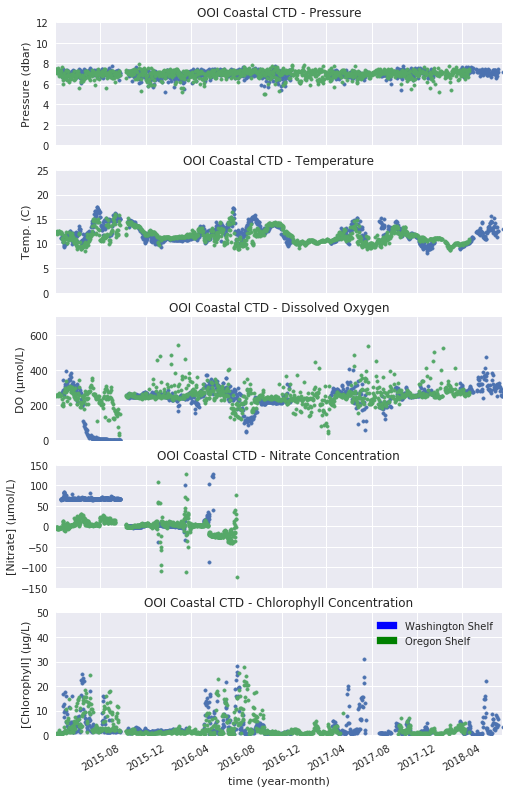

In [0]:
# Plot the Coastal CTD, DO, Nitrate, Chlorophyll
plt.close()
fig,(ax1,ax2,ax3,ax4,ax5) = plt.subplots(5,1, sharex=True, figsize=(8,12))

for jj in range(len(CTDP_data)):
    ax1.scatter(CTDP_data[jj]['time'], CTDP_data[jj]['value'], marker='.')
    ax1.set(ylabel=coastal_CTD_P[jj][0])  
for jj in range(len(CTDT_data)):
    ax2.scatter(CTDT_data[jj]['time'], CTDT_data[jj]['value'], marker='.')
    ax2.set(ylabel=coastal_CTD_T[jj][0])
for jj in range(len(DO_data)):
    ax3.scatter(DO_data[jj]['time'], DO_data[jj]['value'], marker='.')
    ax3.set(ylabel=coastal_DO[jj][0])
for jj in range(len(Nitrate_data)):
    ax4.scatter(Nitrate_data[jj]['time'], Nitrate_data[jj]['value'], marker='.')
    ax4.set(ylabel=coastal_Nitrate[jj][0])
for jj in range(len(Chlorophyll_data)):
    ax5.scatter(Chlorophyll_data[jj]['time'], Chlorophyll_data[jj]['value'], marker='.')
    ax5.set(ylabel=coastal_Chlorophyll[jj][0])
  
plt.xlim(datetime.date(2015,4,2),datetime.date(2018,7,18))
ax1.set_ylim(0,12)
plt.xlabel('time (year-month)')
ax1.set_ylabel('Pressure (dbar)')
plt.xticks(rotation=30)
ax1.title.set_text('OOI Coastal CTD - Pressure')
fig.subplots_adjust(top=0.95)

ax2.set_ylim(0,25)
ax2.set_ylabel('Temp. (C)')
ax2.title.set_text('OOI Coastal CTD - Temperature')

ax3.set_ylim(0,700)
ax3.set_ylabel('DO (µmol/L)')
ax3.title.set_text('OOI Coastal CTD - Dissolved Oxygen')

ax4.set_ylim(-150,150)
ax4.set_ylabel('[Nitrate] (µmol/L)')
ax4.title.set_text('OOI Coastal CTD - Nitrate Concentration')

ax5.set_ylim(0,50)
ax5.set_ylabel('[Chlorophyll] (µg/L)')
ax5.title.set_text('OOI Coastal CTD - Chlorophyll Concentration')

# data lebel

blue_patch = mpatches.Patch(color='blue', label='Washington Shelf')
green_patch = mpatches.Patch(color='green', label='Oregon Shelf')
plt.legend(handles=[blue_patch,green_patch])

plt.show()

The above plots are results of CTD (particularly, pressure and temperature), dissolved oxygen, nitrate, and 3-wavelength fluorometer (particularly chlorophyll concentration) as a function of time since they have been measured. 

According to those plots, there is no obvious pressure variation in both sites. The temperature has a normal fluctuation that it increases during summertime, and decreases during wintertime. 

For ecological aspects, the fluctuation of dissolved oxygen seems to invesely proportional the nitrate and chlorophyll concentration. These are needed to compare with external dataset of USGS discharge variation.

## 6. Comparison to External Dataset (USGS)

![Daily Discharge for Chehalis River, Doty, WA](https://natwebcaww01.wr.usgs.gov/nwisweb/data/img/USGS.12020000.148398.00060.00003.20150402.20180718.log.0..pres.gif)

Reference: https://waterdata.usgs.gov/nwis/dv?cb_00060=on&format=gif_default&site_no=12020000&referred_module=sw&period=&begin_date=2015-04-02&end_date=2018-07-18

![Daily Discharge for Columbia River,Quincy, OR](https://natwebvaww01.er.usgs.gov/nwisweb/data/img/USGS.14246900.114430.00060.00003.20150402.20180718.log.0..pres.gif)
 

Reference: https://waterdata.usgs.gov/nwis/dv?cb_00060=on&format=gif_default&site_no=14246900&referred_module=sw&period=&begin_date=2015-04-02&end_date=2018-07-18

![Daily Discharge for Yaquina River,Chitwood, OR](https://natwebvaww01.er.usgs.gov/nwisweb/data/img/USGS.14306030.114492.00060.00003.19880402.19910718.log.0..pres.gif)

Reference: https://waterdata.usgs.gov/nwis/dv?cb_00060=on&format=gif_default&site_no=14306030&referred_module=sw&period=&begin_date=1988-04-02&end_date=1991-07-18

Note, the discharge fluctuation of Yaquina River near Chitwood, OR does not have a recent record. The way I did is to assume that there is not much variation of fluctuation between 1989-1991 and nowadays. 

The fluctuation says that discharge increases from October to March/April, but decreases between April and October. This can be described as wet winter-dry summer. The fluctuation of discharge somehow be related to the amount of sediment delivered to the ocean.

## 7. A Closer Look

Now, let's look at one year between December 1, 2015 and December 1, 2016. This step is a part of the data that are from the previous step. The data points and time is closer, so the detail of key parameters changed during this time period are considered.

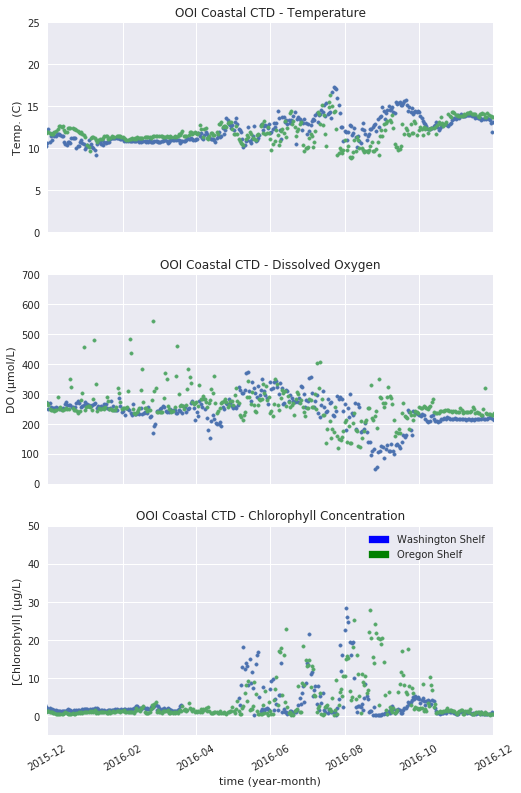

In [0]:
# Plot the Coastal Temperature, DO, Chlorophyll
plt.close()
fig,(ax1,ax2,ax3) = plt.subplots(3,1, sharex=True, figsize=(8,12))

for jj in range(len(CTDT_data)):
    ax1.scatter(CTDT_data[jj]['time'], CTDT_data[jj]['value'], marker='.')
    ax1.set(ylabel=coastal_CTD_T[jj][0])
for jj in range(len(DO_data)):
    ax2.scatter(DO_data[jj]['time'], DO_data[jj]['value'], marker='.')
    ax2.set(ylabel=coastal_DO[jj][0])
for jj in range(len(Chlorophyll_data)):
    ax3.scatter(Chlorophyll_data[jj]['time'], Chlorophyll_data[jj]['value'], marker='.')
    ax3.set(ylabel=coastal_Chlorophyll[jj][0])
  
plt.xlim(datetime.date(2015,12,1),datetime.date(2016,12,1))
ax1.set_ylim(0,25)
plt.xlabel('time (year-month)')
ax1.set_ylabel('Temp. (C)')
plt.xticks(rotation=30)
ax1.title.set_text('OOI Coastal CTD - Temperature')
fig.subplots_adjust(top=0.95)

ax2.set_ylim(0,700)
ax2.set_ylabel('DO (µmol/L)')
ax2.title.set_text('OOI Coastal CTD - Dissolved Oxygen')

ax3.set_ylim(-5,50)
ax3.set_ylabel('[Chlorophyll] (µg/L)')
ax3.title.set_text('OOI Coastal CTD - Chlorophyll Concentration')

# data lebel

blue_patch = mpatches.Patch(color='blue', label='Washington Shelf')
green_patch = mpatches.Patch(color='green', label='Oregon Shelf')
plt.legend(handles=[blue_patch,green_patch])

plt.show()

![Daily suspended sediment concentration for Yaquina River,Chitwood, OR](https://natwebvaww01.er.usgs.gov/nwisweb/data/img/USGS.14306030.114493.80154.00003.19721201.19731201..0..pres.gif)

Reference: https://waterdata.usgs.gov/nwis/dv?cb_80154=on&format=gif_default&site_no=14306030&referred_module=sw&period=&begin_date=1972-12-01&end_date=1973-12-01

The one year cycle of water temperature, dissolved oxygen, and chlorophyll concentration is well illustrated in terms of explaining how ecosystem seasonally changes. When water temperature increases, light can penetrate and be absorbed by algeas and bacteria in the ocean. This causes an increase in productivity of photosynthesis. Simultaneously, the oxygen available in the water is consumed by this tiny creatures for photosyntheis processes. That's why the dissolved oxygen is reduced, while the concentration of chlorophyll increases.

An example of sediment derived from the Yaquina River during 1973 is assumed to behave as similar as today. The concentration of sediment is low during summer, and high during winter due to amount of precipitation. Moreover, it correlates to the productivity of chlorophyll concentration and the reduction of dissolved oxygen.

## 8. Notable Results and Actions Needed

Based on this (somewhat cursory) analysis of the Washington-Oregon shelf geology-ecosystem relationship, we note the following takeaways:

- Pressure is constant 
- Temperature is fluctuation; high during summer, low during winter
- The relationship between dissolved oxygen and nitrate-chlorophyll concentrations are invesely proportional due to the oygen consumption of algeas for photosysthesis and nitrogen production of bacterias for respiratory.
- In Pacific Northwest, discharge records from Chehalis, Columbia, and Yaquina Rivers fluctuates due to wet winter-dry summer 
    - the ammount of sediment delivered is expected to behave similarly to the amount of discharge; high  sediment during high discharge, low sediment during low discharge
    - low amount of dissolved oxygen, but high concentration of chlorophyll correlate with the presence of low sediment
 
In order to strengthen results and interpretation, historical records and ocean/geology/biology concepts are needed for further actions:

- flood dischrge histories 
- possible paleoearthquake records
- deep concepts of ocean mixing, photosynthesis-respiratory concepts